# Airbnb Data Analysis:
These tasks build on the foundational EDA and preprocessing already completed.

In [ ]:
# Load necessary libraries and the dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.stats import shapiro, levene
import warnings
import folium
from folium.plugins import HeatMap
from folium.plugins import MarkerCluster
import geopandas as gpd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Load the processed dataset
data = pd.read_csv('../data/processed_data.csv')

# GeoJSON path for neighbourhood boundaries
geojson_path = "../data/nyc_boroughs.geojson"

## Outlier Handling
Detecting and handling outliers in the `price` column using the Interquartile Range (IQR) method.

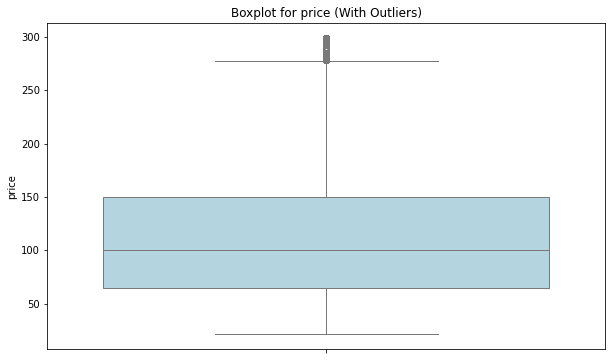

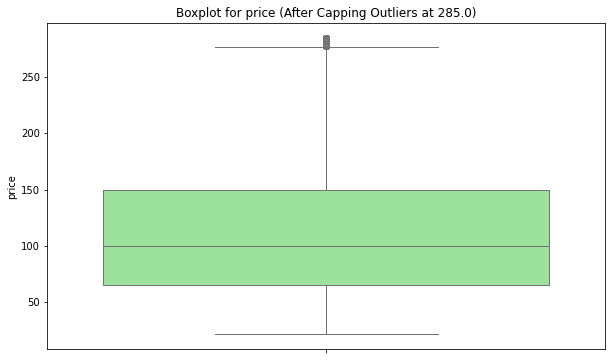

In [2]:
# Outlier Handling Code
def visualize_outliers(data, column, cap=None):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data[column], color='lightblue')
    plt.title(f'Boxplot for {column} (With Outliers)')
    plt.show()

    if cap:
        data = data[data[column] <= cap]
        plt.figure(figsize=(10, 6))
        sns.boxplot(data[column], color='lightgreen')
        plt.title(f'Boxplot for {column} (After Capping Outliers at {cap})')
        plt.show()
        return data
    return data

# Cap price outliers
price_cap = data['price'].quantile(0.99)
data_cleaned = visualize_outliers(data, 'price', cap=price_cap)

## Enhanced Visualisations
Annotated boxplots to highlight trends in `price` and `availability_percentage`.

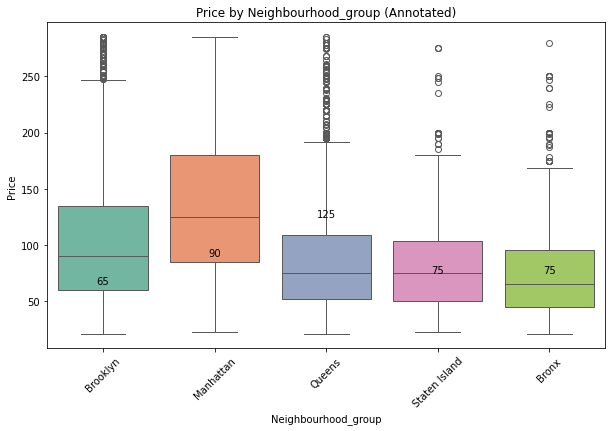

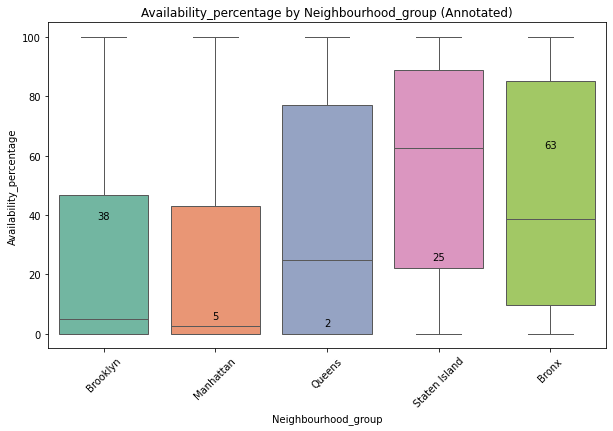

In [3]:
# Annotated Boxplots
def plot_boxplots_with_annotations(data, column, group_by):
    plt.figure(figsize=(10, 6))
    boxplot = sns.boxplot(data=data, x=group_by, y=column, palette='Set2')
    medians = data.groupby(group_by)[column].median()
    for tick, median in enumerate(medians):
        boxplot.text(tick, median, f'{median:.0f}', horizontalalignment='center', color='black')
    plt.title(f'{column.capitalize()} by {group_by.capitalize()} (Annotated)')
    plt.xlabel(group_by.capitalize())
    plt.ylabel(column.capitalize())
    plt.xticks(rotation=45)
    plt.show()

# Boxplots for Price and Availability
plot_boxplots_with_annotations(data_cleaned, 'price', 'neighbourhood_group')
plot_boxplots_with_annotations(data_cleaned, 'availability_percentage', 'neighbourhood_group')

## Statistical Analysis
Conducting ANOVA or Kruskal-Wallis to test if pricing differs significantly across neighborhoods.

In [4]:
# Statistical Tests
from scipy.stats import f_oneway, kruskal

# Check assumptions and perform appropriate test
boroughs = data_cleaned['neighbourhood_group'].unique()
groups = [data_cleaned[data_cleaned['neighbourhood_group'] == borough]['price'] for borough in boroughs]
if all(shapiro(group)[1] > 0.05 for group in groups):
    result = f_oneway(*groups)
    print('ANOVA result:', result)
else:
    result = kruskal(*groups)
    print('Kruskal-Wallis result:', result)

Kruskal-Wallis result: KruskalResult(statistic=4491.681341287426, pvalue=0.0)


## Clustering Analysis
Performing K-Means clustering on key metrics and visualising the results.

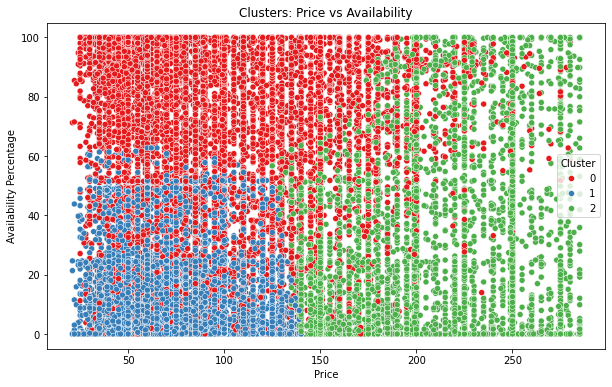

In [5]:
# Clustering Analysis
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Select features for clustering
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_cleaned[['price', 'availability_percentage', 'reviews_per_month']])

# Apply KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
data_cleaned['cluster'] = kmeans.fit_predict(scaled_data)

# Visualise Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data_cleaned['price'], y=data_cleaned['availability_percentage'], hue=data_cleaned['cluster'], palette='Set1')
plt.title('Clusters: Price vs Availability')
plt.xlabel('Price')
plt.ylabel('Availability Percentage')
plt.legend(title='Cluster')
plt.show()

## Outlier Handling

Outliers in pricing can skew the results. We will use the IQR method to handle them.

In [6]:
def handle_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data[column] = np.where(data[column] > upper_bound, upper_bound, data[column])
    return data

# Handle outliers in the price column
data = handle_outliers(data, 'price')
data['price'].describe()

count    40877.000000
mean       114.861132
std         61.686779
min         21.000000
25%         65.000000
50%        100.000000
75%        150.000000
max        277.500000
Name: price, dtype: float64

## Statistical Analysis

We will test whether pricing differs significantly still, after dealing with the outliers, across neighborhoods using ANOVA or Kruskal-Wallis.

In [7]:
groups = [data[data['neighbourhood_group'] == group]['price'] for group in data['neighbourhood_group'].unique()]

# Check normality and equal variance assumptions
normality = all(shapiro(group)[1] > 0.05 for group in groups)
variance = levene(*groups)[1] > 0.05

# Perform the appropriate test
if normality and variance:
    result = f_oneway(*groups)
    print('ANOVA result:', result)
else:
    result = kruskal(*groups)
    print('Kruskal-Wallis result:', result)

Kruskal-Wallis result: KruskalResult(statistic=4627.593557881785, pvalue=0.0)


## Clustering Analysis

Clustering neighborhoods helps identify patterns and potential opportunities.

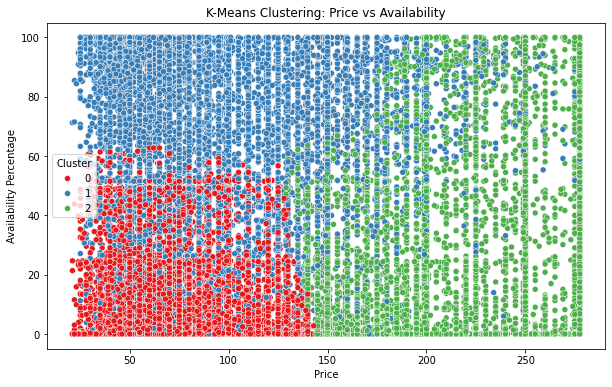

In [8]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[['price', 'availability_percentage', 'reviews_per_month']])

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
data['cluster'] = kmeans.fit_predict(scaled_features)

# Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['price'], y=data['availability_percentage'], hue=data['cluster'], palette='Set1')
plt.title('K-Means Clustering: Price vs Availability')
plt.xlabel('Price')
plt.ylabel('Availability Percentage')
plt.legend(title='Cluster')
plt.show()

## Demand and Availability Map

This map highlights neighborhoods based on demand and availability thresholds:
- **Green Markers:** High-demand, low-availability neighborhoods. These are ideal for new listings or increased pricing strategies.
- **Orange Markers:** Borderline neighborhoods with either moderately high demand or slightly low availability. These could represent potential opportunities.
- **Red Markers:** Neighborhoods to avoid due to low demand and high availability.

The thresholds are dynamically calculated using percentiles to adapt to the data distribution. The interactive popups include details about the neighborhood, such as average reviews, availability, price, and top listings.

In [ ]:
availability_price_analysis = data.groupby(['neighbourhood_group', 'neighbourhood']).agg(
    avg_price=('price', 'mean'),
    avg_availability=('availability_percentage', 'mean'),
    avg_reviews=('reviews_per_month', 'mean'),
    listings_count=('neighbourhood', 'count')  # Count of listings in the neighbourhood
).reset_index()

# Refine thresholds dynamically using percentiles
availability_threshold = availability_price_analysis['avg_availability'].quantile(0.25)  # Low availability threshold (25th percentile)
review_threshold = availability_price_analysis['avg_reviews'].quantile(0.75)  # High demand threshold (75th percentile)

# Define tolerances for borderline cases using median-based flexibility
availability_tolerance = availability_price_analysis['avg_availability'].quantile(0.50)  # Median availability (50th percentile)
review_tolerance = availability_price_analysis['avg_reviews'].quantile(0.50)  # Median reviews (50th percentile)

In [10]:
# Generate data for price heatmap
price_heat_data = [
    [row['latitude'], row['longitude'], row['price']]
    for _, row in data.iterrows()
]

In [ ]:
# Create high-demand, low-availability neighborhoods (Green Markers)
high_demand_low_availability = availability_price_analysis[
    (availability_price_analysis['avg_reviews'] >= review_threshold) &
    (availability_price_analysis['avg_availability'] <= availability_threshold)
]

# Create borderline neighborhoods (Orange Markers), excluding green markers
borderline_neighbourhoods = availability_price_analysis[
    ~availability_price_analysis['neighbourhood'].isin(high_demand_low_availability['neighbourhood']) & (
        ((availability_price_analysis['avg_reviews'] >= review_tolerance) &
         (availability_price_analysis['avg_availability'] <= availability_threshold)) |
        ((availability_price_analysis['avg_reviews'] >= review_threshold) &
         (availability_price_analysis['avg_availability'] <= availability_tolerance))
    )
]

# Create neighborhoods to avoid (Red Markers)
avoid_neighbourhoods = availability_price_analysis[
    (availability_price_analysis['avg_reviews'] <= review_threshold/5) &
    (availability_price_analysis['avg_availability'] >= availability_threshold/5)
]

# Function to generate popup content
def create_popup(row, category):
    # Example placeholder trend (replace with real calculations as needed)
    price_trend = "Price trend: Upward"
    
    # Top listings approximation using 'number_of_reviews'
    top_rated = data[data['neighbourhood'] == row['neighbourhood']].sort_values('number_of_reviews', ascending=False).head(3)
    top_listings = "<br>".join([
        f"- {listing['room_type']} (${listing['price']}, {listing['number_of_reviews']} reviews)"
        for _, listing in top_rated.iterrows()
    ])
    
    return folium.Popup(
        f"<b>{category}</b><br>"
        f"<b>Neighborhood:</b> {row['neighbourhood']}<br>"
        f"<b>Average Reviews:</b> {row['avg_reviews']:.2f}<br>"
        f"<b>Average Availability:</b> {row['avg_availability']:.2f}%<br>"
        f"<b>Average Price:</b> ${row['avg_price']:.2f}<br>"
        f"<b>{price_trend}</b><br>"
        f"<b>Top Listings:</b><br>{top_listings}",
        max_width=300
    )


# Create the flexible map
flexible_map_with_enhanced_markers = folium.Map(location=[40.7128, -74.0060], zoom_start=11)

# Add price heatmap
HeatMap(price_heat_data, min_opacity=0.3, radius=10, blur=15).add_to(flexible_map_with_enhanced_markers)

# Add neighbourhood boundaries
folium.GeoJson(
    geojson_path,
    name="Neighbourhood Boundaries",
    style_function=lambda x: {
        'fillColor': 'none',
        'color': 'blue',
        'weight': 2
    }
).add_to(flexible_map_with_enhanced_markers)

# Add custom markers for high-demand, low-availability neighborhoods (Green)
for _, row in high_demand_low_availability.iterrows():
    latitude = data[data['neighbourhood'] == row['neighbourhood']]['latitude'].mean()
    longitude = data[data['neighbourhood'] == row['neighbourhood']]['longitude'].mean()
    if pd.notnull(latitude) and pd.notnull(longitude):
        folium.Marker(
            location=[latitude, longitude],
            popup=create_popup(row, "Ideal: High Demand, Low Availability"),
            icon=folium.Icon(color='green', icon='star', prefix='fa')  # Star icon
        ).add_to(flexible_map_with_enhanced_markers)

# Add custom markers for borderline neighborhoods (Orange)
for _, row in borderline_neighbourhoods.iterrows():
    latitude = data[data['neighbourhood'] == row['neighbourhood']]['latitude'].mean()
    longitude = data[data['neighbourhood'] == row['neighbourhood']]['longitude'].mean()
    if pd.notnull(latitude) and pd.notnull(longitude):
        folium.Marker(
            location=[latitude, longitude],
            popup=create_popup(row, "Potential Opportunity: Borderline Case"),
            icon=folium.Icon(color='orange', icon='circle', prefix='fa')  # Circle icon
        ).add_to(flexible_map_with_enhanced_markers)

# Add custom markers for areas to avoid (Red)
for _, row in avoid_neighbourhoods.iterrows():
    latitude = data[data['neighbourhood'] == row['neighbourhood']]['latitude'].mean()
    longitude = data[data['neighbourhood'] == row['neighbourhood']]['longitude'].mean()
    if pd.notnull(latitude) and pd.notnull(longitude):
        folium.Marker(
            location=[latitude, longitude],
            popup=create_popup(row, "Avoid: Low Demand, High Availability"),
            icon=folium.Icon(color='red', icon='exclamation-triangle', prefix='fa')  # Caution triangle
        ).add_to(flexible_map_with_enhanced_markers)

# Define our map legend
legend_html = """
<div style="
position: fixed; 
bottom: 50px; left: 50px; width: 350px; height: 130px; 
background-color: white; 
border: 2px solid grey; 
border-radius: 5px; 
z-index:9999; 
font-size:14px;
padding: 10px 15px; 
line-height: 1.8;">
<b>Legend</b><br>
<i class="fa fa-star" style="color: green; font-size: 16px; margin-right: 10px;"></i>
Ideal: High Demand, Low Availability<br>
<i class="fa fa-circle" style="color: orange; font-size: 16px; margin-right: 10px;"></i>
Potential Opportunity: Borderline Case<br>
<i class="fa fa-exclamation-triangle" style="color: red; font-size: 16px; margin-right: 10px;"></i>
Avoid: Low Demand, High Availability
</div>
"""

flexible_map_with_enhanced_markers.get_root().html.add_child(folium.Element(legend_html))

# Save the map
flexible_map_with_enhanced_markers.save("../visualisations/map.html")
print("Enhanced map saved as '../visualisations/map.html'.")

Enhanced map saved as 'visualisations/map.html'.


## Neighborhood Clustering Map

This additional map groups neighborhoods into clusters based on key metrics:
- **Price:** The average price of listings in the neighborhood.
- **Demand:** Represented by the average number of reviews.
- **Availability:** The percentage of days listings are available.

Each cluster highlights neighborhoods with similar characteristics, helping to identify patterns or distinct types of areas. For example, neighborhoods in the same cluster might share similar pricing strategies or listing availability trends.

In [ ]:
from sklearn.cluster import KMeans
from folium.plugins import MarkerCluster, HeatMap

# Refine thresholds dynamically using percentiles
availability_threshold = availability_price_analysis['avg_availability'].quantile(0.25)  # Low availability threshold (25th percentile)
review_threshold = availability_price_analysis['avg_reviews'].quantile(0.75)  # High demand threshold (75th percentile)

# Define tolerances for borderline cases using median-based flexibility
availability_tolerance = availability_price_analysis['avg_availability'].quantile(0.50)  # Median availability (50th percentile)
review_tolerance = availability_price_analysis['avg_reviews'].quantile(0.50)  # Median reviews (50th percentile)

# Assign a marker type for each neighborhood
def get_marker_type(row):
    if row['avg_reviews'] >= review_threshold and row['avg_availability'] <= availability_threshold:
        return 'green'  # High-demand, low-availability
    elif row['avg_reviews'] <= review_threshold / 5 and row['avg_availability'] >= availability_threshold / 5:
        return 'red'  # Avoidable neighborhoods
    else:
        return 'orange'  # Borderline cases

# Add marker type column
availability_price_analysis['marker_type'] = availability_price_analysis.apply(get_marker_type, axis=1)

# Create high-demand, low-availability neighborhoods (Green)
high_demand_low_availability = availability_price_analysis[availability_price_analysis['marker_type'] == 'green']

# Create borderline neighborhoods (Orange)
borderline_neighbourhoods = availability_price_analysis[availability_price_analysis['marker_type'] == 'orange']

# Create neighborhoods to avoid (Red)
avoid_neighbourhoods = availability_price_analysis[availability_price_analysis['marker_type'] == 'red']

# Merge latitude and longitude into availability_price_analysis if missing
availability_price_analysis = availability_price_analysis.merge(
    data[['neighbourhood', 'latitude', 'longitude']],
    on='neighbourhood',
    how='left'
)

# Verify latitude and longitude presence
if 'latitude' not in availability_price_analysis.columns or 'longitude' not in availability_price_analysis.columns:
    raise KeyError("The 'latitude' and 'longitude' columns are missing after the merge.")

# Prepare data for K-means clustering
features = availability_price_analysis[['avg_price', 'avg_reviews', 'avg_availability']].dropna()  # Select clustering features
kmeans = KMeans(n_clusters=3, random_state=42)  # Adjust the number of clusters as needed
availability_price_analysis['cluster'] = kmeans.fit_predict(features)

# Cluster color assignment based on dominant marker type in the cluster
cluster_marker_summary = availability_price_analysis.groupby('cluster')['marker_type'].value_counts().unstack(fill_value=0)

# Assign dominant color to each cluster
def assign_cluster_color(row):
    if row['green'] >= row['orange'] and row['green'] >= row['red']:
        return 'green'
    elif row['red'] >= row['green'] and row['red'] >= row['orange']:
        return 'red'
    else:
        return 'orange'

cluster_marker_summary['cluster_color'] = cluster_marker_summary.apply(assign_cluster_color, axis=1)

# Define the popup creation function
def create_popup(row, category):
    # Example placeholder trend (replace with real calculations as needed)
    price_trend = "Price trend: Upward"
    
    # Top listings approximation using 'number_of_reviews'
    top_rated = data[data['neighbourhood'] == row['neighbourhood']].sort_values('number_of_reviews', ascending=False).head(3)
    top_listings = "<br>".join([
        f"- {listing['room_type']} (${listing['price']}, {listing['number_of_reviews']} reviews)"
        for _, listing in top_rated.iterrows()
    ])
    
    return folium.Popup(
        f"<b>{category}</b><br>"
        f"<b>Neighborhood:</b> {row['neighbourhood']}<br>"
        f"<b>Average Reviews:</b> {row['avg_reviews']:.2f}<br>"
        f"<b>Average Availability:</b> {row['avg_availability']:.2f}%<br>"
        f"<b>Average Price:</b> ${row['avg_price']:.2f}<br>"
        f"<b>{price_trend}</b><br>"
        f"<b>Top Listings:</b><br>{top_listings}",
        max_width=300
    )

# Create the clustered map
clustered_map = folium.Map(location=[40.7128, -74.0060], zoom_start=11)
marker_cluster = MarkerCluster().add_to(clustered_map)

# Add price heatmap
HeatMap(price_heat_data, min_opacity=0.3, radius=10, blur=15).add_to(clustered_map)

# Add borough boundaries
folium.GeoJson(
    geojson_path,
    name="Neighbourhood Boundaries",
    style_function=lambda x: {
        'fillColor': 'none',
        'color': 'blue',
        'weight': 2
    }
).add_to(clustered_map)

# Add individual markers for each neighborhood
for _, row in availability_price_analysis.iterrows():
    latitude = row['latitude']
    longitude = row['longitude']
    marker_type = row['marker_type']
    
    if pd.notnull(latitude) and pd.notnull(longitude):
        folium.Marker(
            location=[latitude, longitude],
            popup=create_popup(row, f"Neighborhood Type: {marker_type.capitalize()}"),
            icon=folium.Icon(color=marker_type, icon='info-sign')
        ).add_to(marker_cluster)

# Add cluster markers with dominant colors
for cluster_id, row in cluster_marker_summary.iterrows():
    cluster_data = availability_price_analysis[availability_price_analysis['cluster'] == cluster_id]
    latitude = cluster_data['latitude'].mean()
    longitude = cluster_data['longitude'].mean()
    cluster_color = row['cluster_color']
    
    folium.Marker(
        location=[latitude, longitude],
        popup=(
            f"<b>Cluster {cluster_id}</b><br>"
            f"Dominant Color: {cluster_color}<br>"
            f"Total Green: {row['green']}<br>"
            f"Total Orange: {row['orange']}<br>"
            f"Total Red: {row['red']}"
        ),
        icon=folium.Icon(color=cluster_color, icon='info-sign')
    ).add_to(clustered_map)

# Define a custom legend
legend_html = """
<div style="
position: fixed; 
bottom: 50px; left: 50px; width: 350px; height: 130px; 
background-color: white; 
border: 2px solid grey; 
border-radius: 5px; 
z-index:9999; 
font-size:14px;
padding: 10px 15px; 
line-height: 1.8;">
<b>Legend</b><br>
<i class="fa fa-star" style="color: green; font-size: 16px; margin-right: 10px;"></i>
Ideal: High Demand, Low Availability<br>
<i class="fa fa-circle" style="color: orange; font-size: 16px; margin-right: 10px;"></i>
Potential Opportunity: Borderline Case<br>
<i class="fa fa-exclamation-triangle" style="color: red; font-size: 16px; margin-right: 10px;"></i>
Avoid: Low Demand, High Availability
</div>
"""

clustered_map.get_root().html.add_child(folium.Element(legend_html))

# Save the clustered map
clustered_map.save("../visualisations/clustered_map_with_dominant_colors.html")
print("Clustered map with dominant colors saved as '../visualisations/clustered_map_with_dominant_colors.html'.")


Clustered map with dominant colors saved as 'visualisations/clustered_map_with_dominant_colors.html'.


In [ ]:
from folium.plugins import MarkerCluster
import geopandas as gpd

# Load GeoJSON data for neighborhoods if centroids are needed
geo_data = gpd.read_file(geojson_path)
geo_data['centroid'] = geo_data['geometry'].centroid

# Create a clustered map
clustered_map = folium.Map(location=[40.7128, -74.0060], zoom_start=11)
marker_cluster = MarkerCluster().add_to(clustered_map)

# Add markers to the cluster for high-demand neighborhoods (Green)
for _, row in high_demand_low_availability.iterrows():
    centroid = geo_data[geo_data['BoroName'] == row['neighbourhood']]['centroid']
    latitude = centroid.y.values[0] if not centroid.empty else data[data['neighbourhood'] == row['neighbourhood']]['latitude'].mean()
    longitude = centroid.x.values[0] if not centroid.empty else data[data['neighbourhood'] == row['neighbourhood']]['longitude'].mean()
    
    if pd.notnull(latitude) and pd.notnull(longitude):
        folium.Marker(
            location=[latitude, longitude],
            popup=create_popup(row, "Ideal: High Demand, Low Availability"),
            icon=folium.Icon(color='green', icon='star', prefix='fa')
        ).add_to(marker_cluster)

# Add markers to the cluster for borderline neighborhoods (Orange)
for _, row in borderline_neighbourhoods.iterrows():
    centroid = geo_data[geo_data['BoroName'] == row['neighbourhood']]['centroid']
    latitude = centroid.y.values[0] if not centroid.empty else data[data['neighbourhood'] == row['neighbourhood']]['latitude'].mean()
    longitude = centroid.x.values[0] if not centroid.empty else data[data['neighbourhood'] == row['neighbourhood']]['longitude'].mean()
    
    if pd.notnull(latitude) and pd.notnull(longitude):
        folium.Marker(
            location=[latitude, longitude],
            popup=create_popup(row, "Potential Opportunity: Borderline Case"),
            icon=folium.Icon(color='orange', icon='circle', prefix='fa')
        ).add_to(marker_cluster)

# Add markers to the cluster for areas to avoid (Red)
for _, row in avoid_neighbourhoods.iterrows():
    centroid = geo_data[geo_data['BoroName'] == row['neighbourhood']]['centroid']
    latitude = centroid.y.values[0] if not centroid.empty else data[data['neighbourhood'] == row['neighbourhood']]['latitude'].mean()
    longitude = centroid.x.values[0] if not centroid.empty else data[data['neighbourhood'] == row['neighbourhood']]['longitude'].mean()
    
    if pd.notnull(latitude) and pd.notnull(longitude):
        folium.Marker(
            location=[latitude, longitude],
            popup=create_popup(row, "Avoid: Low Demand, High Availability"),
            icon=folium.Icon(color='red', icon='exclamation-triangle', prefix='fa')
        ).add_to(marker_cluster)

# Save the clustered map
clustered_map.save("../visualisations/clustered_map.html")
print("Clustered map saved as '../visualisations/clustered_map.html'.")

Clustered map saved as 'visualisations/clustered_map.html'.


In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Select features for clustering
features = availability_price_analysis[['avg_price', 'avg_reviews', 'avg_availability']]

# Handle missing values (if any)
features = features.dropna()

# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Convert back to a DataFrame for clarity
scaled_features_df = pd.DataFrame(scaled_features, columns=['avg_price', 'avg_reviews', 'avg_availability'])

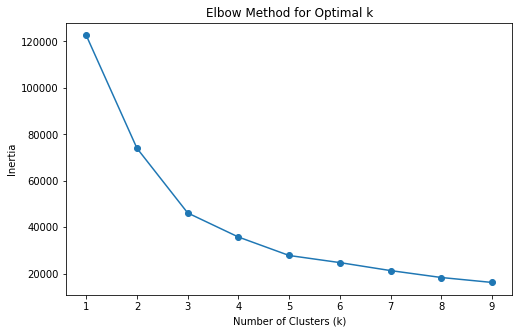

In [15]:
import matplotlib.pyplot as plt

# Calculate inertia for different k values
inertia = []
k_values = range(1, 10)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

In [ ]:
# Apply k-means clustering with the optimal number of clusters
optimal_k = 3  # Determined from the Elbow Method
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
features['cluster'] = kmeans.fit_predict(scaled_features)

availability_price_analysis['cluster'] = features['cluster']

In [ ]:
# Assign colours to clusters
cluster_colors = ['blue', 'purple', 'cyan']  # Adjust as needed for more clusters

# Add markers for each cluster
for _, row in availability_price_analysis.iterrows():
    latitude = data[data['neighbourhood'] == row['neighbourhood']]['latitude'].mean()
    longitude = data[data['neighbourhood'] == row['neighbourhood']]['longitude'].mean()
    cluster_label = row['cluster']
    
    if pd.notnull(latitude) and pd.notnull(longitude):
        folium.Marker(
            location=[latitude, longitude],
            popup=f"Neighborhood: {row['neighbourhood']}<br>Cluster: {cluster_label}",
            icon=folium.Icon(color=cluster_colors[cluster_label], icon='info-sign')
        ).add_to(clustered_map)

# Save the map with clusters
clustered_map.save("visualisations/clustered_map_with_kmeans.html")
print("Clustered map with k-means saved as '../visualisations/clustered_map_with_kmeans.html'.")

Clustered map with k-means saved as 'visualisations/clustered_map_with_kmeans.html'.
